# Dense Neural Network Model

### Step 1: Import library

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import keras_tuner as kt
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.callbacks import EarlyStopping


from utils import evaluate_model_performance, time_sequence_generator, plot_mae_mse,create_results_dataframe, plot_actual_vs_predicted, load_and_preprocess_data
import importlib

import utils
importlib.reload(utils) 

<module 'utils' from '/Users/mac/Desktop/kingston/Deep-learning-assignment/utils.py'>

### Step 2: Import training data

In [3]:
data = load_and_preprocess_data()

### Step 3: Separate the data to Train, Validation & Test 


In [4]:
from utils import split_train_validate_test

train_data, validation_data, test_data = split_train_validate_test(data, 0.7, 0.15, 0.15)


### Step 4: Data Feature extraction

In [ ]:
from pandas import DataFrame

## Extract feature from the data
def extract_feature(d: DataFrame):
    """
    Minimal feature set optimized for CNN+LSTM
    Returns:
        - Features DataFrame
        - Target Series (Open price)
    """
    D = DataFrame()
    dt = pd.to_datetime(d['Time'], unit='s')
    
    # 1. Core Time Features (CNN will detect patterns)
    D['day_of_year'] = dt.dt.dayofyear  # 1-365
    D['week_of_year'] = dt.dt.isocalendar().week  # 1-52
    D['hour'] = dt.dt.hour  # 0-23
    
    # 2. Essential Price Features (LSTM will learn sequences)
    if 'Open' in d.columns:
        # Raw prices and lags
        D['open_price'] = d['Open']
        for lag in [1, 2, 3, 5, 7]:  # Short-term lags for CNN
            D[f'lag_{lag}'] = d['Open'].shift(lag)
        
        # Volatility measure
        D['range_5day'] = d['Open'].rolling(5).max() - d['Open'].rolling(5).min()
    
    # 3. Binary Market States
    D['is_london_hours'] = ((dt.dt.hour >= 7) & (dt.dt.hour < 16)).astype(int)
    
    # Drop NA and align
    D.dropna(inplace=True)
    if 'Open' in d.columns:
        y = d.loc[D.index, 'Open']
        return D, y
    return D

X_train = extract_feature(train_data)
y_train = train_data['Open']

X_val = extract_feature(validation_data)
y_val = validation_data['Open']

X_test = extract_feature(test_data)
y_test = test_data['Open']


X_whole = extract_feature(data)

### Step 5: Scaling the data

In [6]:
features = ['Day', 'Month', 'Year', 'DayOfWeek', 'DayOfYear', 'WeekOfYear']

scaler = MinMaxScaler()
scaler.fit(X_train[features].values)

X_train_scaled = scaler.transform(X_train[features].values)
X_val_scaled = scaler.transform(X_val[features].values)
X_test_scaled = scaler.transform(X_test[features].values)

X_whole_scaled = scaler.transform(X_whole[features].values)

### Step 2: Hyper-tuning the model 

In [14]:
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
print(X_train_scaled.shape)
def build_cnn_lstm_model(hp):
    model = Sequential()
    
    model.add(InputLayer(input_shape=X_train_scaled.shape[1]))
    
    # Tune CNN layers
    for i in range(hp.Int('num_cnn_layers', 1, 3)):
        model.add(Conv1D(
            filters=hp.Int(f'filters_{i}', 32, 128, step=32),
            kernel_size=hp.Int(f'kernel_size_{i}', 2, 5),
            activation='relu',
            padding='same'
        ))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(
            pool_size=hp.Int(f'pool_size_{i}', 1, 2)
        ))
        model.add(Dropout(
            hp.Float(f'cnn_dropout_{i}', 0.1, 0.5, step=0.1)
        ))
    
    # Tune LSTM layers
    for i in range(hp.Int('num_lstm_layers', 1, 2)):
        model.add(LSTM(
            units=hp.Int(f'lstm_units_{i}', 64, 256, step=64),
            return_sequences=(i < hp.get('num_lstm_layers') - 1)
        ))
        model.add(Dropout(
            hp.Float(f'lstm_dropout_{i}', 0.1, 0.5, step=0.1)
        ))
    
    # Tune Dense layers
    for i in range(hp.Int('num_dense_layers', 1, 3)):
        model.add(Dense(
            units=hp.Int(f'dense_units_{i}', 32, 128, step=32),
            activation='relu'
        ))
        model.add(Dropout(
            hp.Float(f'dense_dropout_{i}', 0.1, 0.4, step=0.1)
        ))
    
    # Output layer
    model.add(Dense(1))
    
    # Tune learning rate
    lr = hp.Float('lr', 1e-4, 1e-3, sampling='log')
    
    model.compile(
        optimizer=kt.optimizers.Adam(learning_rate=lr, clipvalue=0.5),
        loss='mae',
        metrics=['mae', 'mse']
    )
    return model

# Verify your data shapes first
print("Input shape:", X_train_scaled.shape)  # Should be (samples, timesteps, features)
timesteps = X_train_scaled.shape[1]
n_features = X_train_scaled.shape[2]

# Initialize tuner
tuner = kt.Hyperband(
    hypermodel=build_cnn_lstm_model,
    objective='val_mae',
    max_epochs=100,
    factor=3,
    directory='tuning',
    project_name='gbpusd_cnn_lstm',
    overwrite=True
)

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_mae',
    patience=15,
    restore_best_weights=True
)

# Run search
tuner.search(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=2
)
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest Hyperparameters:")
print(f"CNN Layers: {best_hps.get('num_cnn_layers')}")
print(f"LSTM Layers: {best_hps.get('num_lstm_layers')}")
print(f"Dense Layers: {best_hps.get('num_dense_layers')}")
print(f"Learning Rate: {best_hps.get('lr'):.6f}")

# Build and train the final model
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=200,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

(840, 6)
Input shape: (840, 6)


IndexError: tuple index out of range

### Step 6: Best Parameters

In [ ]:
print("-----------Best Parameter------")
best_hps_table = pd.DataFrame(list(best_hps.values.items()), columns=["Hyperparameter", "Value"])
print(best_hps_table)

-----------Best Parameter------
         Hyperparameter     Value
0            num_layers         9
1               units_0       448
2             dropout_0       0.4
3               units_1       384
4             dropout_1       0.4
5               units_2       256
6             dropout_2       0.5
7               units_3       384
8             dropout_3       0.5
9               units_4       384
10            dropout_4       0.2
11              units_5       384
12            dropout_5       0.4
13                   lr  0.002553
14              units_6       256
15            dropout_6       0.5
16              units_7       288
17            dropout_7       0.3
18              units_8       320
19            dropout_8       0.3
20              units_9       320
21            dropout_9       0.2
22         tuner/epochs        34
23  tuner/initial_epoch        12
24        tuner/bracket         2
25          tuner/round         1
26       tuner/trial_id      0220


### Step 6: Evaluation

In [ ]:
## Predict the values on the test data 
y_pred = dnn_model.predict(X_test_scaled)
evaluate_model_performance(y_test.values, y_pred)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Model Performance on Test Data:
------------------------
R^2 Score: -5.1301
Mean Absolute Error (MAE): 0.0518
Mean Squared Error (MSE): 0.0037
Mean Absolute Percentage Error (MAPE): 3.78%


### Step 7: Plotting MAE & MSE

KeyError: 'mse'

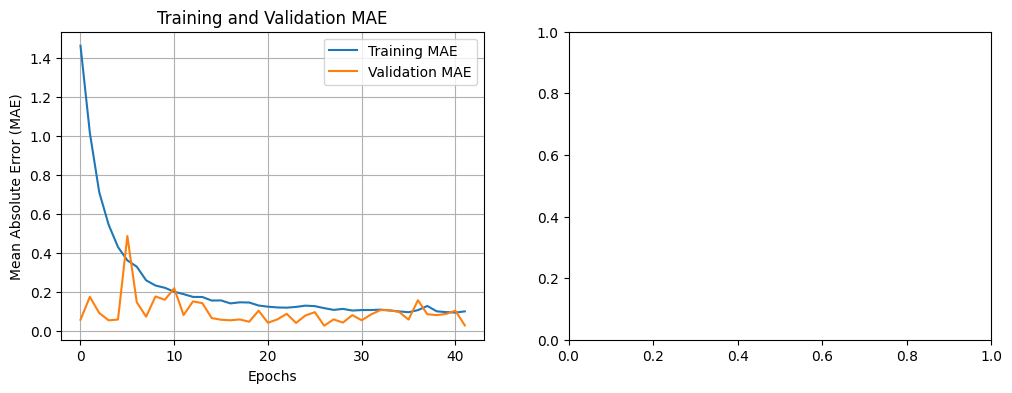

In [ ]:
# plot_mae_mse(history)

### Step 8: Plot the data predicted & actual

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step


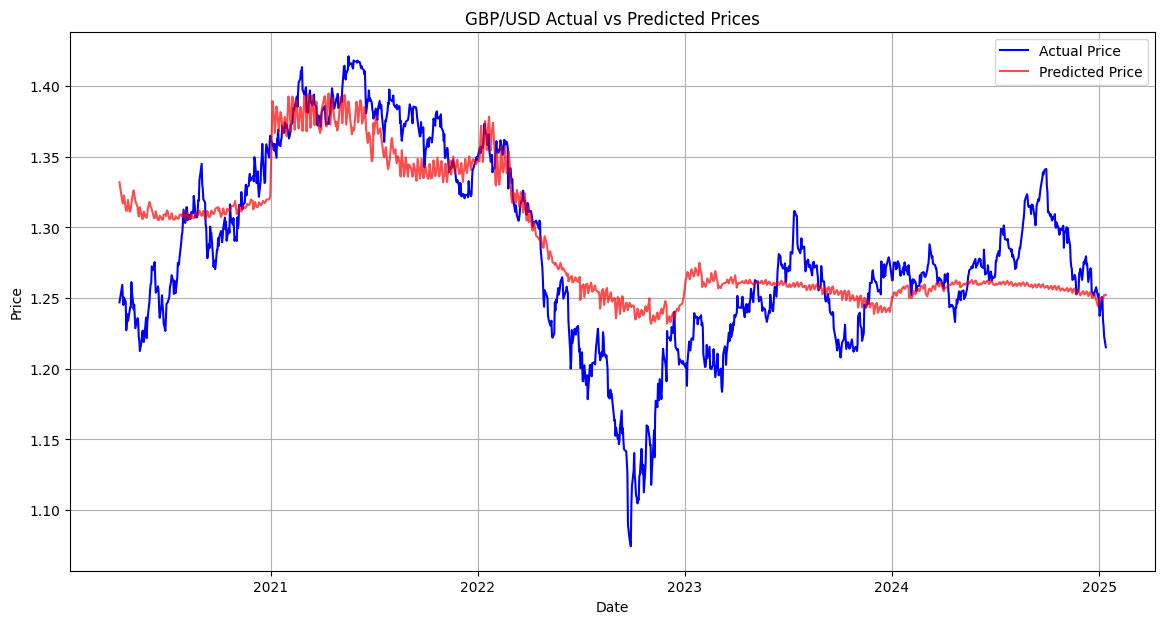

In [ ]:
 
def create_results_dataframe(dnn_model, X_scaled, data: DataFrame):
    """
    Create a DataFrame with actual and predicted prices.
    """
    print(X_scaled)
    predictions = dnn_model.predict(X_scaled).flatten()
    results = pd.DataFrame({
        'Date': data['Date'],
        'Actual_Price': data['Open'].values,
        'Predicted_Price': predictions
    })
    return results

def plot_actual_vs_predicted(results):
    """
    Plot actual vs predicted prices.
    """
    plt.figure(figsize=(14, 7))
    plt.plot(results['Date'], results['Actual_Price'], label='Actual Price', color='blue')
    plt.plot(results['Date'], results['Predicted_Price'], label='Predicted Price', color='red', alpha=0.7)
    plt.title('GBP/USD Actual vs Predicted Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
# Generate results DataFrame
results = create_results_dataframe(dnn_model, X_whole_scaled, data)
# Plot actual vs predicted prices
plot_actual_vs_predicted(results)

In [ ]:
dnn_model.save('gbpusd_price_predictor.h5')